In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
import pandas as pd
import random
import shutil
import warnings
from PIL import Image # image processing
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory # load images from directory
from tensorflow.keras import callbacks # use EarlyStopping
from tensorflow.keras.preprocessing import image
# Reproducability
# def set_seed(seed=31415):
#     np.random.seed(seed)
#     tf.random.set_seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     os.environ['TF_DETERMINISTIC_OPS'] = '1'
# set_seed(31415)

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

2024-09-17 18:09:37.211852: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-17 18:09:37.212005: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-17 18:09:37.334223: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
df_train = pd.read_csv('/kaggle/input/thcr-1/train.csv')
df_test = pd.read_csv('/kaggle/input/thcr-1/test.csv')

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62870 entries, 0 to 62869
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           62870 non-null  object
 1   Class Label  62870 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 982.5+ KB


In [9]:
df_train.head()

,ID,Class Label
0,1.bmp,2
1,2.bmp,3
2,3.bmp,4
3,4.bmp,5
4,5.bmp,6


In [10]:
width, height = Image.open(
    '/kaggle/input/thcr-1/Train-Kaggle/Train-Kaggle/1.bmp'
).size
print(f'Width: {width}px, Height: {height}px')

Width: 64px, Height: 64px


In [11]:
tamil_characters = ['ா', 'அ', 'ஆ', 'இ', 'ஈ', 'உ', 'ஊ', 'எ', 'ஏ', 'ஐ', 'ஒ', 'ஓ', 'ஔ','ஃ','க்','க', 'கி', 'கீ', 'கு', 'கூ','ச்', 'ச','சி', 'சீ', 'சு','சூ','ங்', 'ங', 'ஙி', 'ஙீ', 'ஙு', 'ஙூ','ஞ்','ஞ','ஞி','ஞீ','ஞு','ஞூ','ட்','ட',"ழ",'டீ','டு','டூ','ண்','ண', 'ணி','ணீ','ணு','ணூ','த்','த', 'தி', 'தீ', 'து', 'தூ','ந்', 'ந', 'நி', 'நீ', 'நு', 'நூ','ப்','ப', 'பி', 'பீ', 'பு', 'பூ', 'ம்','ம', 'மி', 'மீ', 'மு', 'மூ','ய்','ய', 'யி', 'யீ', 'யு', 'யூ','ர்', 'ர', 'ரி', 'ரீ', 'ரு', 'ரூ', 'ல்','ல', 'லி', 'லீ', 'லு', 'லூ', 'ன்',  'ன', 'னி', 'னீ', 'ளு', 'ளூ', 'ற்','ற', 'றி', 'றீ', 'று', 'றூ', 'வ்','வ', 'வி', 'வீ', 'வு', 'வூ','ழ்','ழ', 'ழி', 'ழீ', 'ழு', 'ழூ','ன்', 'ன', 'னி',' னீ',' னு', 'ஷி', 'ஷீ', 'ஷு', 'ஷூ','க்ஷ', 'க்ஷ்',' க்ஷி',' க்ஷீ','ஜு', 'ஜூ','ஹ','ஹ்', 'ஹி', 'ஹீ', 'ஹு', 'ஹூ', 'ஸ','ஸ்', 'ஸி', 'ஸீ', 'ஸு', 'ஸூ', 'ஷ','ஷ்', 'னூ','ஶ்ரீ','க்ஷூ','ஜ','ஜ்','ஜி', 'ஜீ','க்ஷீ', 'ெ', 'ே', 'ை']# Creating a dictionary with characters as keys and their index as values
tamil_dict = {index: char for index, char in enumerate(tamil_characters)}
print(tamil_dict)

{0: 'ா', 1: 'அ', 2: 'ஆ', 3: 'இ', 4: 'ஈ', 5: 'உ', 6: 'ஊ', 7: 'எ', 8: 'ஏ', 9: 'ஐ', 10: 'ஒ', 11: 'ஓ', 12: 'ஔ', 13: 'ஃ', 14: 'க்', 15: 'க', 16: 'கி', 17: 'கீ', 18: 'கு', 19: 'கூ', 20: 'ச்', 21: 'ச', 22: 'சி', 23: 'சீ', 24: 'சு', 25: 'சூ', 26: 'ங்', 27: 'ங', 28: 'ஙி', 29: 'ஙீ', 30: 'ஙு', 31: 'ஙூ', 32: 'ஞ்', 33: 'ஞ', 34: 'ஞி', 35: 'ஞீ', 36: 'ஞு', 37: 'ஞூ', 38: 'ட்', 39: 'ட', 40: 'ழ', 41: 'டீ', 42: 'டு', 43: 'டூ', 44: 'ண்', 45: 'ண', 46: 'ணி', 47: 'ணீ', 48: 'ணு', 49: 'ணூ', 50: 'த்', 51: 'த', 52: 'தி', 53: 'தீ', 54: 'து', 55: 'தூ', 56: 'ந்', 57: 'ந', 58: 'நி', 59: 'நீ', 60: 'நு', 61: 'நூ', 62: 'ப்', 63: 'ப', 64: 'பி', 65: 'பீ', 66: 'பு', 67: 'பூ', 68: 'ம்', 69: 'ம', 70: 'மி', 71: 'மீ', 72: 'மு', 73: 'மூ', 74: 'ய்', 75: 'ய', 76: 'யி', 77: 'யீ', 78: 'யு', 79: 'யூ', 80: 'ர்', 81: 'ர', 82: 'ரி', 83: 'ரீ', 84: 'ரு', 85: 'ரூ', 86: 'ல்', 87: 'ல', 88: 'லி', 89: 'லீ', 90: 'லு', 91: 'லூ', 92: 'ன்', 93: 'ன', 94: 'னி', 95: 'னீ', 96: 'ளு', 97: 'ளூ', 98: 'ற்', 99: 'ற', 100: 'றி', 101: 'றீ', 102: 'று', 103: '

In [12]:
label = 'Class Label'
len(df_train[label].unique())
print(df_train[label].unique())

[  2   3   4   5   6   7   9  10  11  12  14  15  16  17  19  20  13  18
   0  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155   8  21  22  23  24  25  26  27  28  29  30  31  32  33
  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79   1  80]


In [13]:
image_train_directory = '/kaggle/input/thcr-1/Train-Kaggle/Train-Kaggle'
image_test_directory = '/kaggle/input/thcr-1/Test-Kaggle/Test-Kaggle'
df_train = df_train.sort_values(by='ID')
df_test = df_test.sort_values(by='ID')

In [14]:
train_labels = df_train[label].tolist()

train_ds, val_ds = image_dataset_from_directory(
    image_train_directory,
    labels=train_labels,
    label_mode='int',
    validation_split=0.2, # 20% for validation
    subset='both',
    seed=123, # no overlap of training and validation
    image_size=(64,64), 
    batch_size=32
)

test_ds = image_dataset_from_directory(
    image_test_directory,
    labels=None,
    label_mode=None,
    image_size=(64,64)
)

Found 62870 files belonging to 156 classes.
Using 50296 files for training.
Using 12574 files for validation.
Found 28080 files.


In [20]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
class SelfAttention(layers.Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.f = layers.Conv2D(self.channels // 8, 1, activation='relu')  # Query convolution
        self.g = layers.Conv2D(self.channels // 8, 1, activation='relu')  # Key convolution
        self.h = layers.Conv2D(self.channels, 1, activation='relu')      # Value convolution
        self.gamma = self.add_weight(name='gamma', shape=[1], initializer='zeros', trainable=True)
        super(SelfAttention, self).build(input_shape)

    def call(self, x):
        f = self.f(x)
        g = self.g(x)
        h = self.h(x)

        s = tf.matmul(tf.reshape(g, shape=[-1, self.channels // 8]),
                      tf.reshape(f, shape=[-1, self.channels // 8]), transpose_b=True)  # Attention map
        beta = tf.nn.softmax(s)  # Softmax attention map

        o = tf.matmul(beta, tf.reshape(h, shape=[-1, self.channels]))
        o = tf.reshape(o, shape=tf.shape(x))  # Reshape to original shape
        output = self.gamma * o + x  # Scale and add with original input
        return output


In [22]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class CBAM(layers.Layer):
    def __init__(self, reduction_ratio=16, kernel_size=7, **kwargs):
        super(CBAM, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio
        self.kernel_size = kernel_size

    def build(self, input_shape):
        self.channel_axis = -1
        self.filters = input_shape[self.channel_axis]

        self.shared_mlp = tf.keras.Sequential([
            layers.Dense(self.filters // self.reduction_ratio, activation='relu'),
            layers.Dense(self.filters)
        ])

        self.conv = layers.Conv2D(1, 
                                  kernel_size=self.kernel_size,
                                  padding='same', 
                                  activation='sigmoid')

        super(CBAM, self).build(input_shape)

    def call(self, input_tensor):
        # Channel Attention
        avg_pool = tf.reduce_mean(input_tensor, axis=[1, 2], keepdims=True)
        max_pool = tf.reduce_max(input_tensor, axis=[1, 2], keepdims=True)

        avg_mlp = self.shared_mlp(avg_pool)
        max_mlp = self.shared_mlp(max_pool)
        channel_attention = layers.Activation('sigmoid')(avg_mlp + max_mlp)
        channel_refined = input_tensor * channel_attention

        # Spatial Attention
        avg_pool = tf.reduce_mean(channel_refined, axis=self.channel_axis, keepdims=True)
        max_pool = tf.reduce_max(channel_refined, axis=self.channel_axis, keepdims=True)
        spatial_attention = layers.Concatenate(axis=self.channel_axis)([avg_pool, max_pool])
        spatial_attention = self.conv(spatial_attention)
        output_tensor = channel_refined * spatial_attention
        return output_tensor

In [23]:
def create_model():
    inputs = tf.keras.Input(shape=(64, 64, 3))
    x = layers.Rescaling(1. / 255)(inputs)

    # Conv1
    x = layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same')(x)
    x = CBAM()(x)  # CBAM after Conv1
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.25)(x)

    # Conv2
    x = layers.Conv2D(filters=32, kernel_size=2, activation='relu', padding='same')(x)
    x = CBAM()(x)  # CBAM after Conv2
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.25)(x)

    # Conv3
    x = layers.Conv2D(filters=64, kernel_size=2, activation='relu', padding='same')(x)
    x = CBAM()(x)  # CBAM after Conv3
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.25)(x)

    # Final Self-Attention
    x = SelfAttention()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(units=256, activation='relu')(x)
    x = layers.Dropout(0.50)(x)
    outputs = layers.Dense(units=156, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model
model = create_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cbam_3 (CBAM)                   │ (None, 64, 64, 16)     │           148 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cbam_4 (CBAM)                   │ (None, 32, 32, 32)     │           261 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cbam_5 (CBAM)                   │ (None, 16, 16, 64)     │           679 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention_1                │ (None, 8, 8, 64)       │         5,201 │
│ (SelfAttention)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 156)            │        40,092 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,105,997 (4.22 MB)

 Trainable params: 1,105,997 (4.22 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [25]:
# early_stopping = callbacks.EarlyStopping(
#     monitor='val_loss',
#     min_delta=0.001, 
#     patience=3, 
#     restore_best_weights=True
# )

In [25]:
history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=50, 
                    verbose=1)


Epoch 1/50


2024-09-17 18:21:36.704154: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.83228, expected 2.93226
2024-09-17 18:21:36.704200: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.90754, expected 3.00751
2024-09-17 18:21:36.704210: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.19262, expected 4.2926
2024-09-17 18:21:36.704218: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.35803, expected 3.45801
2024-09-17 18:21:36.704225: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.16718, expected 4.26716
2024-09-17 18:21:36.704233: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.22399, expected 4.32397
2024-09-17 18:21:36.704241: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.09103, expected 5.191
2024-09-17 18:21:36.704248: E external/local_xla/xla/servi

  24/1572 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.0051 - loss: 5.0500       

I0000 00:00:1726597304.576619     154 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 232/1572 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.0085 - loss: 5.0443

2024-09-17 18:21:49.623847: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.55778, expected 3.05067
2024-09-17 18:21:49.623904: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 2.94902, expected 2.44191
2024-09-17 18:21:49.623919: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 127: 3.88772, expected 3.38061
2024-09-17 18:21:49.623932: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 191: 3.81603, expected 3.30892
2024-09-17 18:21:49.623950: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 256: 4.02767, expected 3.52056
2024-09-17 18:21:49.623962: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 319: 3.74697, expected 3.23986
2024-09-17 18:21:49.623974: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 320: 3.97011, expected 3.46299
2024-09-17 18:21:49.623985: E external/local

1566/1572 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3351 - loss: 3.1030

2024-09-17 18:22:23.279011: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.0349, expected 3.28203
2024-09-17 18:22:23.279061: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.95954, expected 4.20666
2024-09-17 18:22:23.279070: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.65326, expected 4.90039
2024-09-17 18:22:23.279078: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.67083, expected 3.91795
2024-09-17 18:22:23.279086: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.3988, expected 4.64593
2024-09-17 18:22:23.279094: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.93804, expected 4.18517
2024-09-17 18:22:23.279102: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 6.40849, expected 5.65561
2024-09-17 18:22:23.279110: E external/local_xla/xla/serv

1572/1572 ━━━━━━━━━━━━━━━━━━━━ 108s 26ms/step - accuracy: 0.3362 - loss: 3.0972 - val_accuracy: 0.8758 - val_loss: 0.4559
Epoch 2/50
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8267 - loss: 0.6209 - val_accuracy: 0.9150 - val_loss: 0.2952
Epoch 3/50
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8764 - loss: 0.4330 - val_accuracy: 0.9302 - val_loss: 0.2452
Epoch 4/50
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8978 - loss: 0.3511 - val_accuracy: 0.9356 - val_loss: 0.2162
Epoch 5/50
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9089 - loss: 0.2998 - val_accuracy: 0.9419 - val_loss: 0.1999
Epoch 6/50
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9232 - loss: 0.2508 - val_accuracy: 0.9466 - val_loss: 0.1891
Epoch 7/50
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9293 - loss: 0.2237 - val_accuracy: 0.9447 - val_loss: 0.1838
Epoch 8/50
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9346 - loss: 0.2097 - v

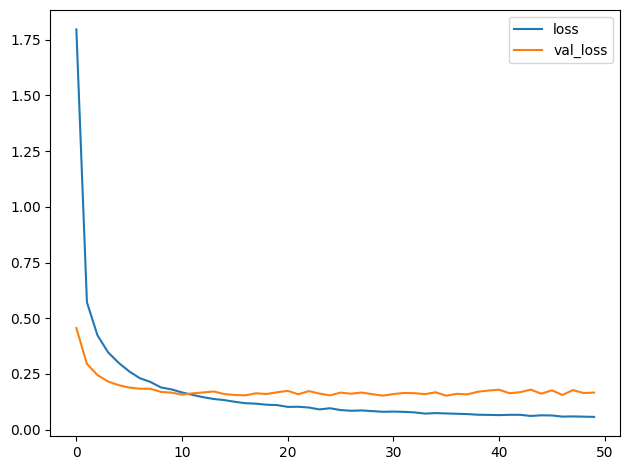

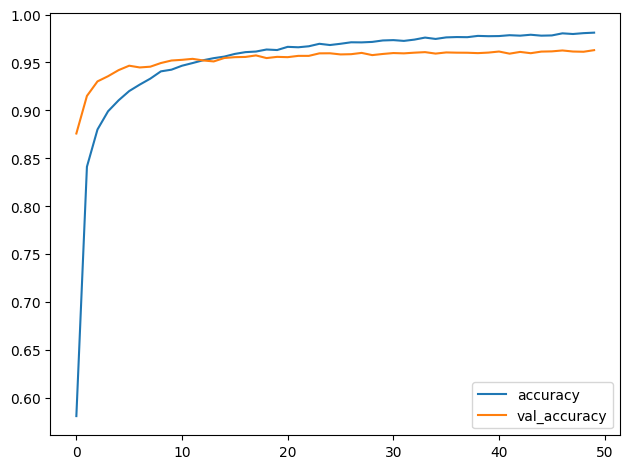

In [26]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.savefig('/kaggle/working/ValLoss.png')
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.savefig('/kaggle/working/ValAccuracy.png')

In [27]:
model.save('model-CNN+CBAM+SA.h5')

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class CBAM(layers.Layer):
    def __init__(self, reduction_ratio=16, kernel_size=7, **kwargs):
        super(CBAM, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio
        self.kernel_size = kernel_size

    def build(self, input_shape):
        self.channel_axis = -1
        self.filters = input_shape[self.channel_axis]

        self.shared_mlp = tf.keras.Sequential([
            layers.Dense(self.filters // self.reduction_ratio, activation='relu'),
            layers.Dense(self.filters)
        ])

        self.conv = layers.Conv2D(1, 
                                  kernel_size=self.kernel_size,
                                  padding='same', 
                                  activation='sigmoid')

        super(CBAM, self).build(input_shape)

    def call(self, input_tensor):
        # Channel Attention
        avg_pool = tf.reduce_mean(input_tensor, axis=[1, 2], keepdims=True)
        max_pool = tf.reduce_max(input_tensor, axis=[1, 2], keepdims=True)

        avg_mlp = self.shared_mlp(avg_pool)
        max_mlp = self.shared_mlp(max_pool)
        channel_attention = layers.Activation('sigmoid')(avg_mlp + max_mlp)
        channel_refined = input_tensor * channel_attention

        # Spatial Attention
        avg_pool = tf.reduce_mean(channel_refined, axis=self.channel_axis, keepdims=True)
        max_pool = tf.reduce_max(channel_refined, axis=self.channel_axis, keepdims=True)
        spatial_attention = layers.Concatenate(axis=self.channel_axis)([avg_pool, max_pool])
        spatial_attention = self.conv(spatial_attention)
        output_tensor = channel_refined * spatial_attention
        return output_tensor

In [29]:
class SelfAttention(layers.Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.f = layers.Conv2D(self.channels // 8, 1, activation='relu')  # Query convolution
        self.g = layers.Conv2D(self.channels // 8, 1, activation='relu')  # Key convolution
        self.h = layers.Conv2D(self.channels, 1, activation='relu')      # Value convolution
        self.gamma = self.add_weight(name='gamma', shape=[1], initializer='zeros', trainable=True)
        super(SelfAttention, self).build(input_shape)

    def call(self, x):
        f = self.f(x)
        g = self.g(x)
        h = self.h(x)

        s = tf.matmul(tf.reshape(g, shape=[-1, self.channels // 8]),
                      tf.reshape(f, shape=[-1, self.channels // 8]), transpose_b=True)  # Attention map
        beta = tf.nn.softmax(s)  # Softmax attention map

        o = tf.matmul(beta, tf.reshape(h, shape=[-1, self.channels]))
        o = tf.reshape(o, shape=tf.shape(x))  # Reshape to original shape
        output = self.gamma * o + x  # Scale and add with original input
        return output


In [30]:
tf.keras.utils.get_custom_objects().update({'CBAM': CBAM,'SelfAttention':SelfAttention})

model = tf.keras.models.load_model('/kaggle/input/abelation-models/model-CNNCBAMSA.h5')

In [31]:
tamil_dict={0: 'ா', 1: 'அ', 2: 'ஆ', 3: 'இ', 4: 'ஈ', 5: 'உ', 6: 'ஊ', 7: 'எ', 8: 'ஏ', 9: 'ஐ', 10: 'ஒ', 11: 'ஓ', 12: 'ஔ', 13: 'ஃ', 14: 'க்', 
15: 'க', 16: 'கி', 17: 'கீ', 18: 'கு', 19: 'கூ', 20: 'ச்', 21: 'ச', 22: 'சி', 23: 'சீ', 24: 'சு', 25: 'சூ', 26: 'ங்', 27: 'ங', 28: 'ஙி', 29: 'ஙீ', 30: 'ஙு', 
31: 'ஙூ', 32: 'ஞ்', 33: 'ஞ', 34: 'ஞி', 35: 'ஞீ', 36: 'ஞு', 37: 'ஞூ', 38: 'ட்', 39: 'ட', 40: 'ழ',41: 'டீ', 42: 'டு', 43: 'டூ', 44: 'ண்', 45: 'ண', 
46: 'ணி', 47: 'ணீ', 48: 'ணு', 49: 'ணூ', 50: 'த்', 51: 'த', 52: 'தி', 53: 'தீ', 54: 'து', 55: 'தூ', 56: 'ந்', 57: 'ந', 58: 'நி', 59: 'நீ', 60: 'நு',
61: 'நூ', 62: 'ப்', 63: 'ப', 64: 'பி', 65: 'பீ', 66: 'பு', 67: 'பூ', 68: 'ம்', 69: 'ம', 70: 'மி', 71: 'மீ', 72: 'மு', 73: 'மூ', 74: 'ய்', 75: 'ய', 
76: 'யி', 77: 'யீ',78: 'யு', 79: 'யூ', 80: 'ர்', 81: 'ர', 82: 'ரி', 83: 'ரீ', 84: 'ரு', 85: 'ரூ', 86: 'ல்', 87: 'ல', 88: 'லி', 89: 'லீ', 90: 'லு', 
91: 'லூ', 92: 'ன்', 93: 'ன', 94: 'னி', 95: 'னீ', 96: 'ளு', 97: 'ளூ', 98: 'ற்', 99: 'ற', 100: 'றி', 101: 'றீ', 102: 'று', 103: 'றூ', 104: 'வ்', 
105: 'வ', 106: 'வி', 107: 'வீ', 108: 'வு', 109: 'வூ', 110: 'ழ்', 111: 'ழ', 112: 'ழி', 113: 'ழீ', 114: 'ழு', 115: 'ழூ', 116: 'ன்', 117: 'ன', 118: 'னி',
119: 'னீ', 120: 'னு',121: 'ஷி', 122: 'ஷீ', 123: 'ஷு', 124: 'ஷூ', 125: 'க்ஷ', 126: 'க்ஷ்', 127: ' க்ஷி', 128: ' க்ஷீ', 129: 'ஜு', 130: 'ஜூ', 
131: 'ஹ', 132: 'ஹ்', 133: 'ஹி', 134: 'ஹீ', 135: 'ஹு', 136: 'ஹூ', 137: 'ஸ', 138: 'ஸ்', 139: 'ஸி', 140: 'ஸீ', 141: 'ஸு', 142: 'ஸூ', 
143: 'ஷ', 144: 'ஷ்', 145: 'னூ', 146: 'ஶ்ரீ', 147: 'க்ஷூ', 148: 'ஜ', 149: 'ஜ்', 150: 'ஜி', 151: 'ஜீ', 152: 'க்ஷீ', 153: 'ெ', 154: 'ே', 155: 'ை'}

In [32]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
def predict_image(filename,model):
    img_ = image.load_img(filename, target_size=(64, 64))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)    
    prediction = model.predict(img_processed)
    index = np.argmax(prediction)
    return tamil_dict[index]
    plt.imshow(img_array)

In [33]:
predict_image('/kaggle/input/thcr-1/Train-Kaggle/Train-Kaggle/10003.bmp',model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


'ா'

In [34]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import image
import os

# Load the CSV file
df = pd.read_csv('/kaggle/input/thcr-1/train.csv')

# Define the path to the images
image_path = '/kaggle/input/thcr-1/Train-Kaggle/Train-Kaggle/'

# Load your model (replace with actual model loading code)
# model = your_model_loading_function()

def predict_image(filename, model):
    img_ = image.load_img(filename, target_size=(64, 64))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_processed,verbose=0)
    index = np.argmax(prediction)
    return index

# Select only the first 50 rows
df_first_10000 = df.head(10000)

# Predict class labels and add to dataframe
df_first_10000['Predicted_Class_Label'] = df_first_10000['ID'].apply(
    lambda x: predict_image(os.path.join(image_path, f"{x}"), model)
)

# Save the updated CSV file
df_first_10000.to_csv('/kaggle/working/updated_train_CBAM-SA.csv', index=False)


Accuracy: 0.9575
Precision (Macro Average): 0.9527
Recall (Macro Average / Sensitivity): 0.9511
F1 Score (Macro Average): 0.9513
Specificity (Macro Average): 0.9997


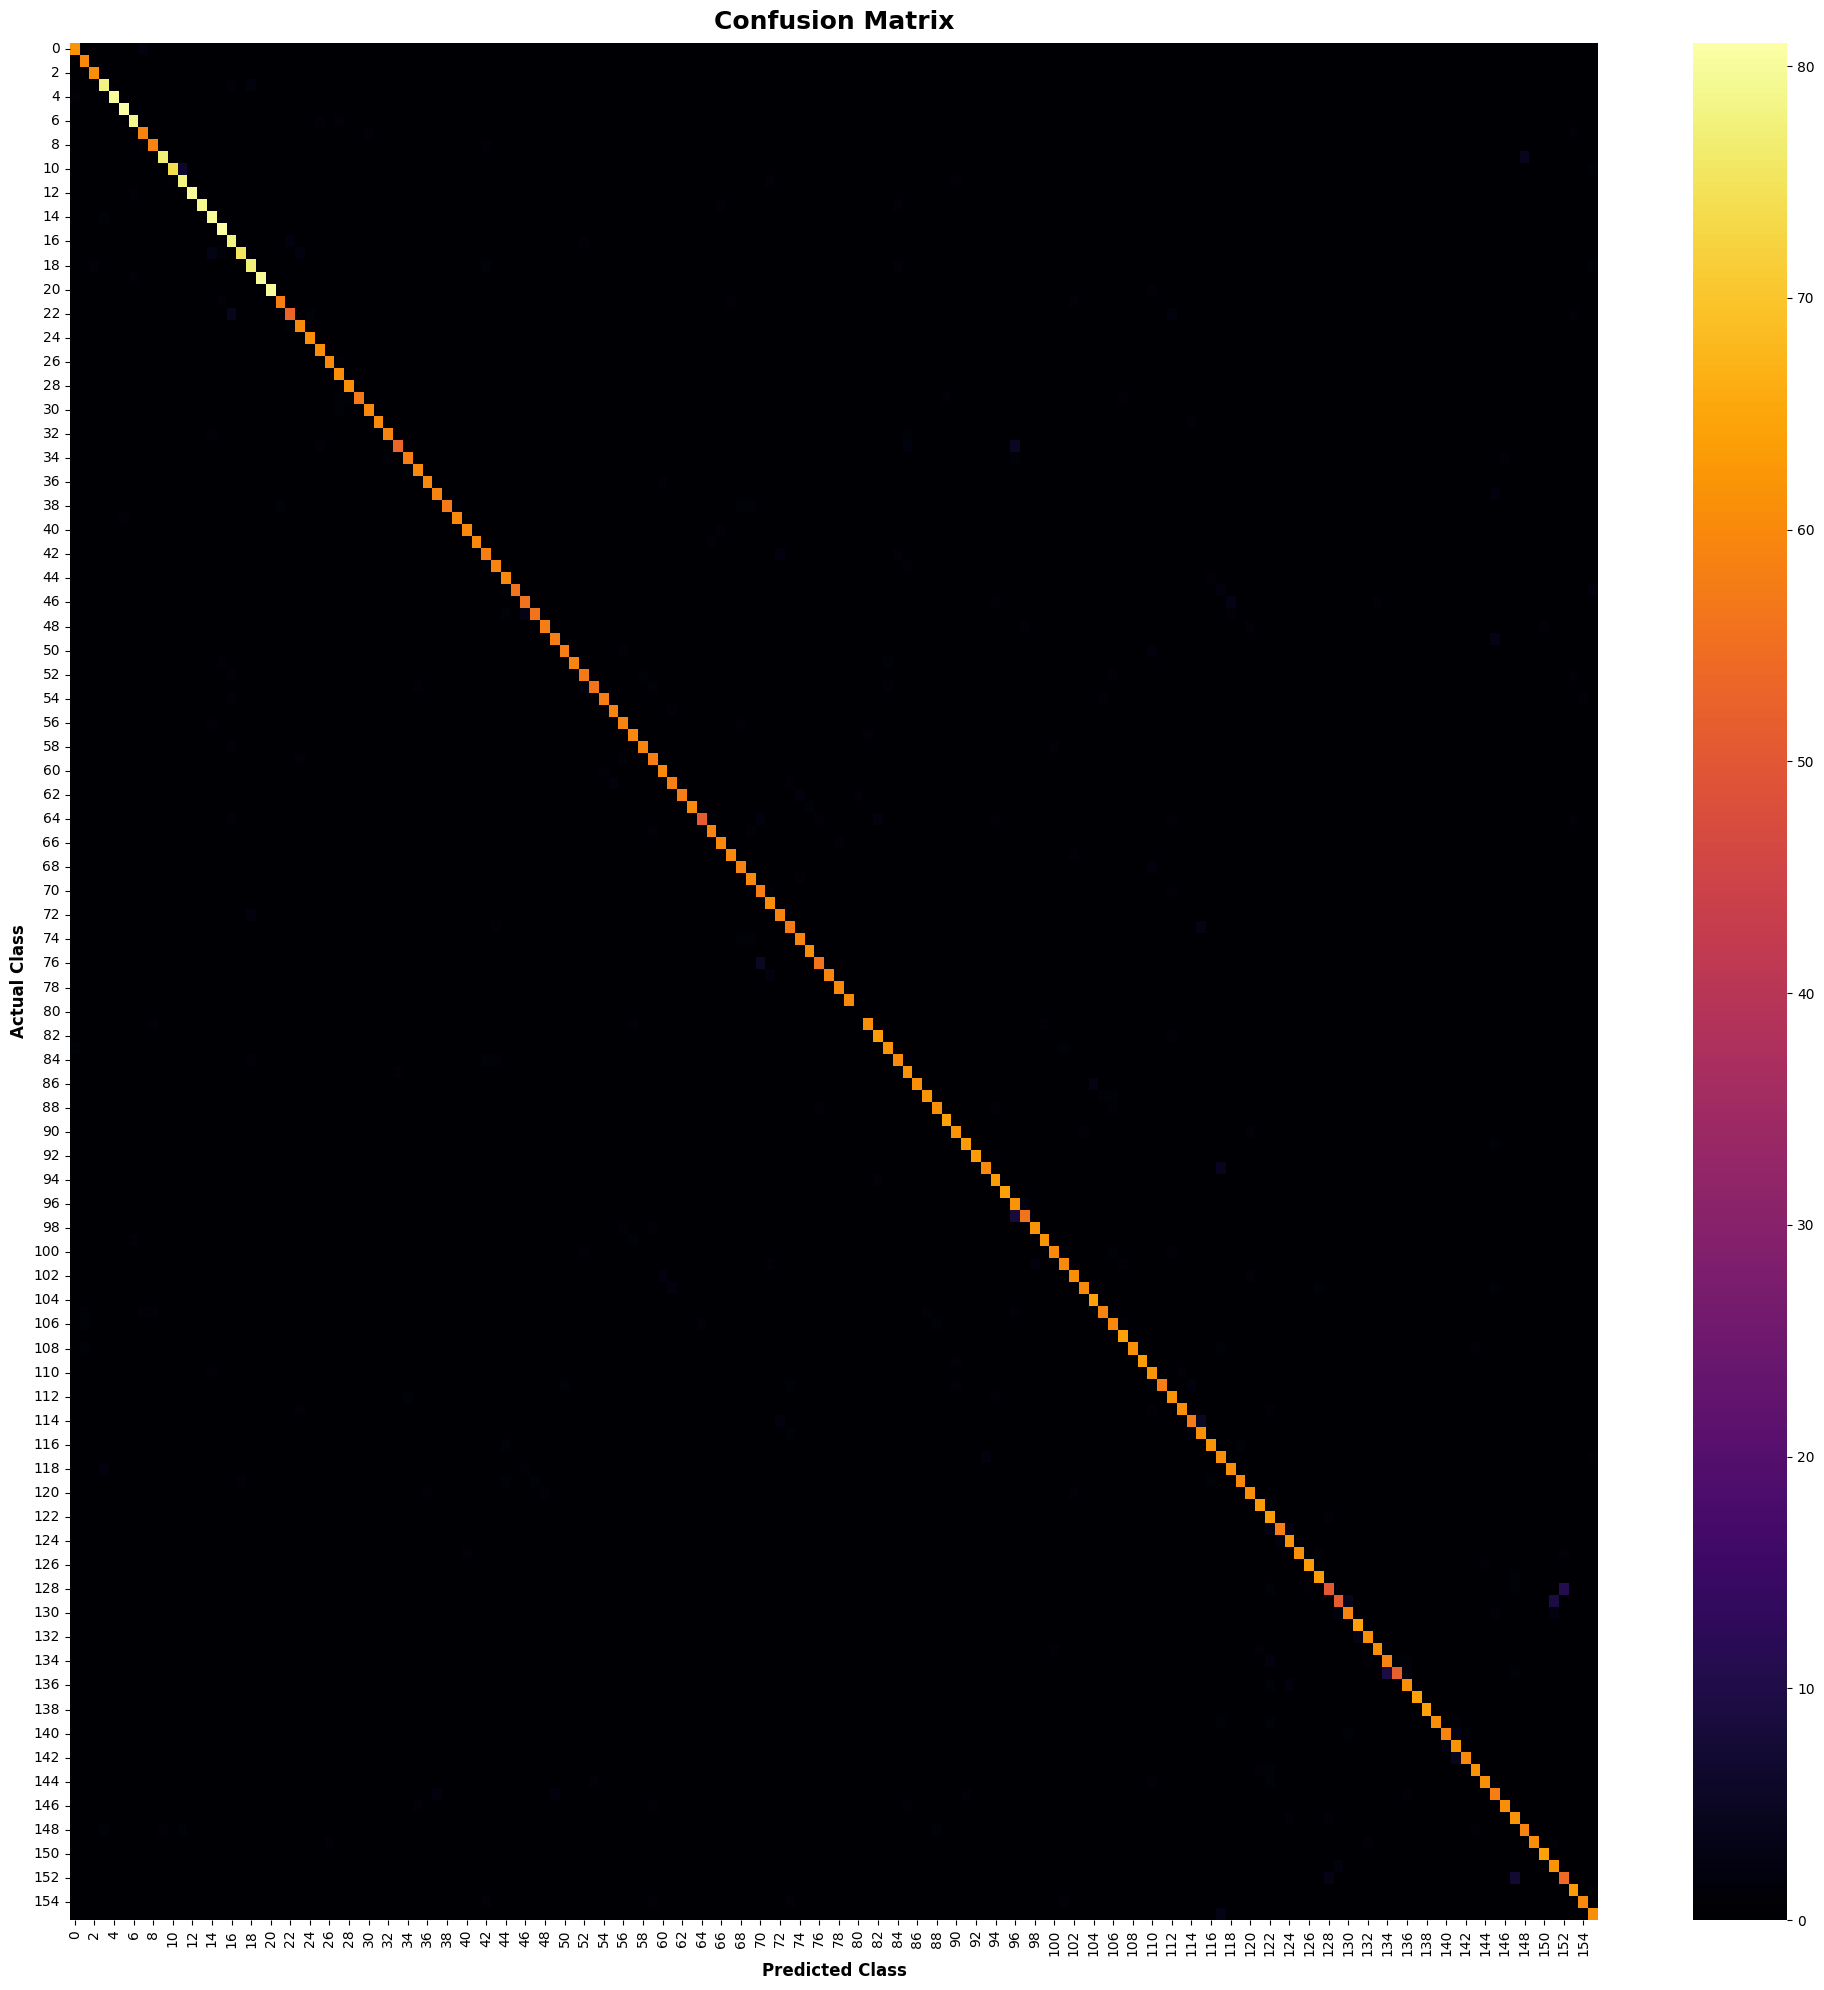

<Figure size 640x480 with 0 Axes>

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


df = pd.read_csv('/kaggle/working/updated_train_CBAM-SA.csv')


y_true = df['Class Label']
y_pred = df['Predicted_Class_Label']


cm = confusion_matrix(y_true, y_pred, labels=range(156))

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Calculate sensitivity and specificity
# Sensitivity is the same as recall
sensitivity = recall

# Specificity calculation for each class
specificity = []
for i in range(156):
    tn = cm.sum() - (cm[:, i].sum() + cm[i, :].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity.append(tn / (tn + fp))

avg_specificity = sum(specificity) / len(specificity)

# Print calculated metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Macro Average): {precision:.4f}")
print(f"Recall (Macro Average / Sensitivity): {sensitivity:.4f}")
print(f"F1 Score (Macro Average): {f1:.4f}")
print(f"Specificity (Macro Average): {avg_specificity:.4f}")

# Plot confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=False, cmap='inferno', fmt='d')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.show()
plt.savefig('/kaggle/working/confusion-matrix')


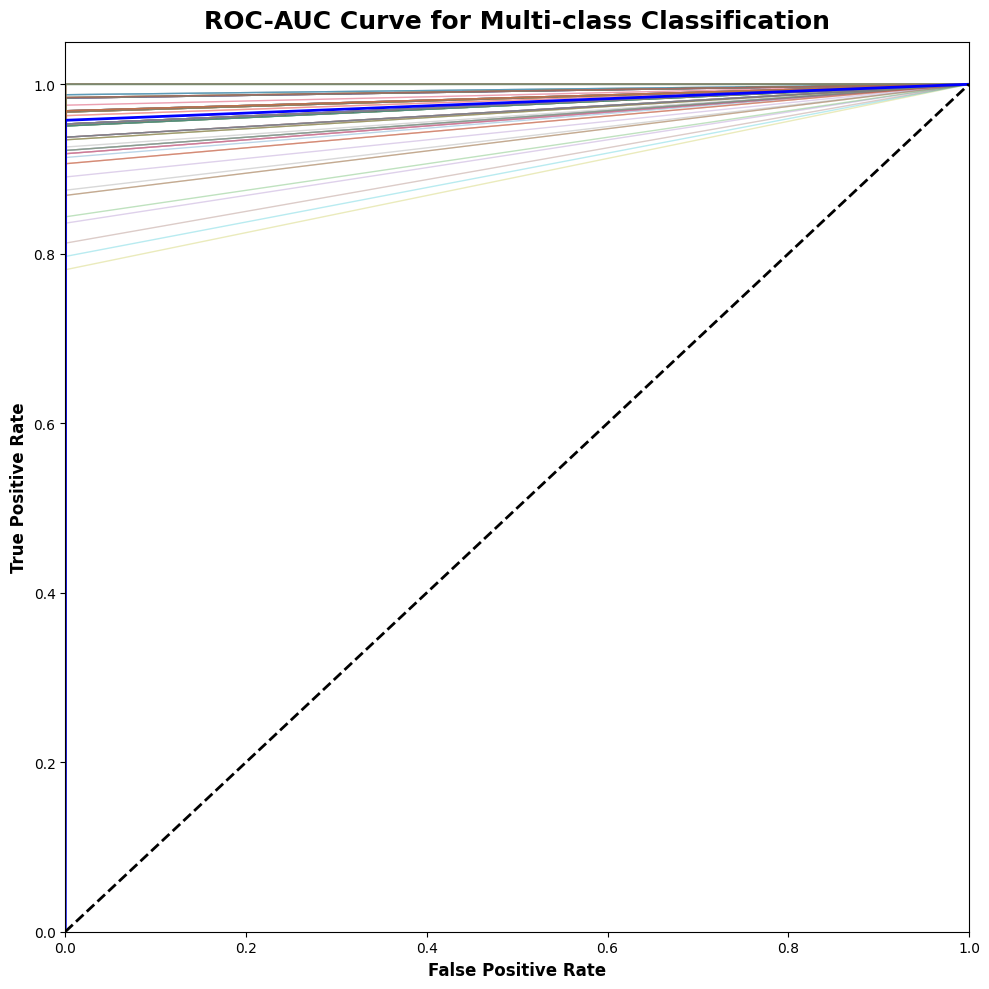

<Figure size 640x480 with 0 Axes>

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

df = pd.read_csv('/kaggle/working/updated_train_CBAM-SA.csv')
y_true = df['Class Label']
y_pred = df['Predicted_Class_Label']

y_true_bin = label_binarize(y_true, classes=range(156))
y_pred_bin = label_binarize(y_pred, classes=range(156))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(156):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_pred_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

plt.figure(figsize=(10, 10))

for i in range(156):
    plt.plot(fpr[i], tpr[i], lw=1, alpha=0.3)

plt.plot(fpr_micro, tpr_micro, color='blue', linestyle='-', linewidth=2, label=f'Micro-average ROC curve (AUC = {roc_auc_micro:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for Multi-class Classification')
plt.show()
plt.savefig('/kaggle/working/learning-curve')
